In [1]:
from scipy.io import readsav
import matplotlib.pyplot as plt
import numpy as np
import datetime
from dateutil import parser
import math
# import geopack.geopack as gp
# import ephem
# from ai import cs
import os
import netCDF4 as nc
from apexpy import Apex

In [2]:
folder = '/Volumes/My Passport/data/GOLD/on2/'

In [3]:
filelist = []

for root, dirs, files in os.walk(folder):
    for file in files:
        #append the file name to the list
        if '._' not in file and '.D' not in file:
            filelist.append(os.path.join(root,file))
filelist.sort()

In [4]:
ds = nc.Dataset(filelist[0])
for var in ds.variables.values():
    print(var)

<class 'netCDF4._netCDF4.Variable'>
int32 mask_oi_1356(nmask)
    FORMAT: I1
    VALIDMIN: 0
    DEPEND_0: nscans
    FIELDNAM: Wavelength mask used to extract OI 135.6 nm brightness.
    VAR_TYPE: support data
    FILLVAL: -999999999
    VALIDMAX: 1
    CATDESC: Wavelength mask used to extract OI 135.6 nm brightness.
unlimited dimensions: 
current shape = (4001,)
filling on, default _FillValue of -2147483647 used
<class 'netCDF4._netCDF4.Variable'>
float32 n2_lbh_unc_ran(nscans, nlats, nlons)
    FORMAT: E10.3
    DEPEND_1: nlats
    FIELDNAM: N2 LBH Radiance Random Uncertainty
    DEPEND_0: nscans
    VALIDMIN: 0.0
    LABLAXIS: N2 LBH Radiance Random Uncertainty
    DEPEND_2: nlons
    UNITS: Rayleighs
    VAR_TYPE: data
    FILLVAL: nan
    DISPLAY_TYPE: map_image
    CATDESC: N2 LBH Radiance Random Uncertainty
    VALIDMAX: 100000.0
unlimited dimensions: nscans
current shape = (68, 52, 46)
filling on, default _FillValue of 9.969209968386869e+36 used
<class 'netCDF4._netCDF4.Variab

In [5]:
on2=ds['on2']
lat=ds['latitude']
lon=ds['longitude']
st_time=ds['scan_start_time']
en_time=ds['scan_stop_time']
ch=ds['channel']
dqi=ds['dqi']
on2_dqi=ds['on2_dqi']

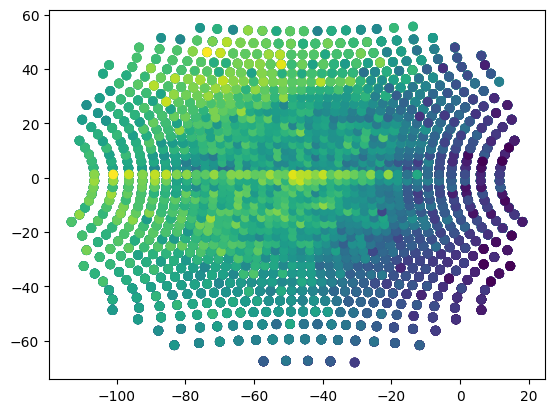

In [6]:
for i in range(on2.shape[2]):
    plt.scatter(lon[:], lat[:], c=on2[i,:,:])

In [7]:
# Deal with string in ncdf
starttime=[]
endtime=[]
channel=[]
for i in range(st_time.shape[0]):
    index=st_time[i].mask
    starttime.append(st_time[i, ~index].tobytes().decode("utf-8"))
    endtime.append(en_time[i, ~index].tobytes().decode("utf-8"))
    index=ch[i].mask
    channel.append(ch[i, ~index].tobytes().decode("utf-8"))

In [8]:
def geo2mag_sphere_apex(lat,lon,h,t):
    
    # GEOPACK is based on a centered dipole coordinate.
    t1 = parser.parse(t)
    
    A = Apex(date=t1)
    mlat, mlon = A.convert(lat, lon, 'geo', 'apex', height=0)
    mlt = A.mlon2mlt(mlon, t1)
    return mlat, mlon, mlt

In [9]:
def mag2geo_sphere_apex(mlat,mlon,h,t):
    
    # GEOPACK is based on a centered dipole coordinate.
    t1 = parser.parse(t)
    
    A = Apex(date=t1)
    lat, lon = A.convert(mlat, mlon, 'apex', 'geo', height=0)
    mlt = A.mlon2mlt(mlon, t1)
    return lat, lon, mlt

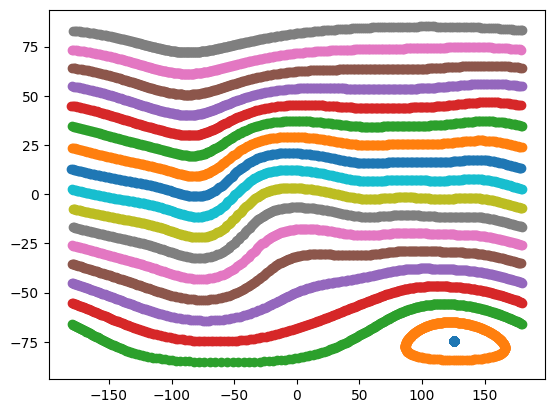

In [10]:
# test apex

lateq=np.zeros([360,])
loneq=np.zeros([360,])

for j in range(-90,90,10):
    for i in range(360): # lat.shape[0]
        lateq[i], loneq[i], _=mag2geo_sphere_apex(j,i,0,starttime[0][:-1])
    
    plt.scatter(loneq,lateq)

In [11]:
# test apex mlt, compared with aacgm
mlat, mlon, mlt=geo2mag_sphere_apex(40,40,0,starttime[0][:-1])
print(starttime[0][:-1], mlat,mlon,mlt)

2019-01-01T06:10:31 35.45655059814453 112.56793975830078 8.894235738118489


In [12]:
on2_rebin_lt=np.empty((180,120),dtype=object)
on2_rebin_lon=np.empty((180,120),dtype=object)

for i in range(180):
    for j in range(120):
        on2_rebin_lt[i,j]=[]
        on2_rebin_lon[i,j]=[]

In [ ]:
for t, f in enumerate(filelist):
    ds = nc.Dataset(f)
    print(f, datetime.datetime.now())
    on2=ds['on2']
    lat=ds['latitude']
    lon=ds['longitude']
    st_time=ds['scan_start_time']
    en_time=ds['scan_stop_time']
    ch=ds['channel']
    dqi=ds['dqi']
    on2_dqi=ds['on2_dqi']
    starttime=[]
    endtime=[]
    channel=[]
    for i in range(st_time.shape[0]):
        index=st_time[i].mask
        starttime.append(st_time[i, ~index].tobytes().decode("utf-8"))
        endtime.append(en_time[i, ~index].tobytes().decode("utf-8"))
        index=ch[i].mask
        channel.append(ch[i, ~index].tobytes().decode("utf-8"))
    
    for i in range(on2.shape[0]):
        if dqi[i]==0:
            for j in range(on2.shape[1]):
                for k in range(on2.shape[2]): 
                    if not np.isnan(on2[i,j,k]) and on2_dqi[i,j,k]==0 and channel[i]=='CHA':
                        glat=lat[j,k]
                        glon=lon[j,k]
                        dtime=parser.parse(starttime[i][0:-1])
                        doy=dtime.timetuple().tm_yday
                        lt=glon/15+dtime.hour+dtime.minute/60
                        if lt>24: lt=lt-24
        #                 month=int(starttime[i][5:7])-1
                        x=int(glat+90)
                        y=int(lt*15/3)
                        on2_rebin_lt[x,y].append((dtime,float(on2[i,j,k])))
                        x=int(glat+90)
                        y=int(glon/3+60)
                        on2_rebin_lon[x,y].append((dtime,float(on2[i,j,k])))
    if t % 100 ==0:
        np.save('on2_rebin_lt.npy', on2_rebin_lt)
        np.save('on2_rebin_lon.npy', on2_rebin_lon)
np.save('on2_rebin_lt.npy', on2_rebin_lt)
np.save('on2_rebin_lon.npy', on2_rebin_lon)

/Volumes/My Passport/data/GOLD/on2/2019/001/GOLD_L2_ON2_2019_001_v03_r01_c01.nc 2023-09-05 16:56:56.811998
/Volumes/My Passport/data/GOLD/on2/2019/002/GOLD_L2_ON2_2019_002_v03_r01_c01.nc 2023-09-05 16:59:44.262702


In [319]:
k=0
for i in range(180):
    for j in range(120):
        if len(on2_rebin_mlt[i,j])>0:
            k=k+1
print(k/120/180)

0.38324074074074077


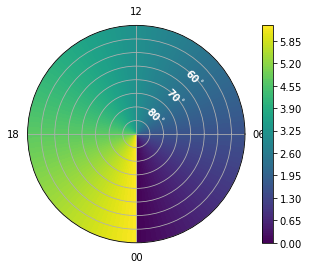

In [24]:
lt_labels = ['06',   '12', '18',   '00']
xticks    = [   0,   np.pi/2,   np.pi, 3*np.pi/2]

# Create contour:
r, theta = np.meshgrid(np.linspace(90,0,90), np.linspace(0,24,180)/24*2*np.pi)
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
cnt1 = ax.contourf(theta-np.pi/2., r, theta, levels=128)

# Set xtick label size, increase font of top label.
labels = ax.get_xticklabels()
for l in labels: l.set_size(10)
labels[1].set_size(10)
        
cbar = plt.colorbar(cnt1, ax=ax)

ax.set_xticks(xticks)
ax.set_xticklabels(lt_labels)

ax.set_ylim([0,40])

# Use text function to manually add pretty ticks.
ax.set_yticklabels('') # old ticks off.
opts = {'size':10, 'rotation':-45, 'ha':'center', 'va':'center'}
for theta in [80.,70.,60.]:
    txt = '{:02.0f}'.format(theta)+r'$^{\circ}$'
    ax.text(np.pi/4., 90.-theta, txt, color='w', weight='heavy', **opts)
#     ax.text(np.pi/4., 90.-theta, txt, color='k', weight='light', **opts)

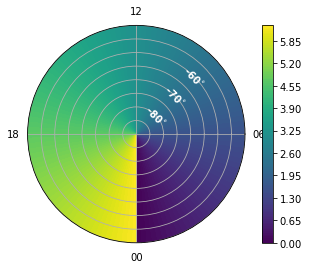

In [23]:
# Create contour:
r, theta = np.meshgrid(np.linspace(0,90,90), np.linspace(0,24,180)/24*2*np.pi)
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
cnt1 = ax.contourf(theta-np.pi/2., r, theta, levels=128)

# Set xtick label size, increase font of top label.
labels = ax.get_xticklabels()
for l in labels: l.set_size(10)
labels[1].set_size(10)
        
cbar = plt.colorbar(cnt1, ax=ax)

ax.set_xticks(xticks)
ax.set_xticklabels(lt_labels)

ax.set_ylim([0,40])

# Use text function to manually add pretty ticks.
ax.set_yticklabels('') # old ticks off.
opts = {'size':10, 'rotation':-45, 'ha':'center', 'va':'center'}
for theta in [80.,70.,60.]:
    txt = '{:02.0f}'.format(-theta)+r'$^{\circ}$'
    ax.text(np.pi/4., 90.-theta, txt, color='w', weight='heavy', **opts)
#     ax.text(np.pi/4., 90.-theta, txt, color='k', weight='light', **opts)